In [95]:
import os
import time
import pickle
from pathlib import Path
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.model.predictor import Predictor
from gluonts.evaluation.backtest import make_evaluation_predictions

import warnings
warnings.filterwarnings("ignore")

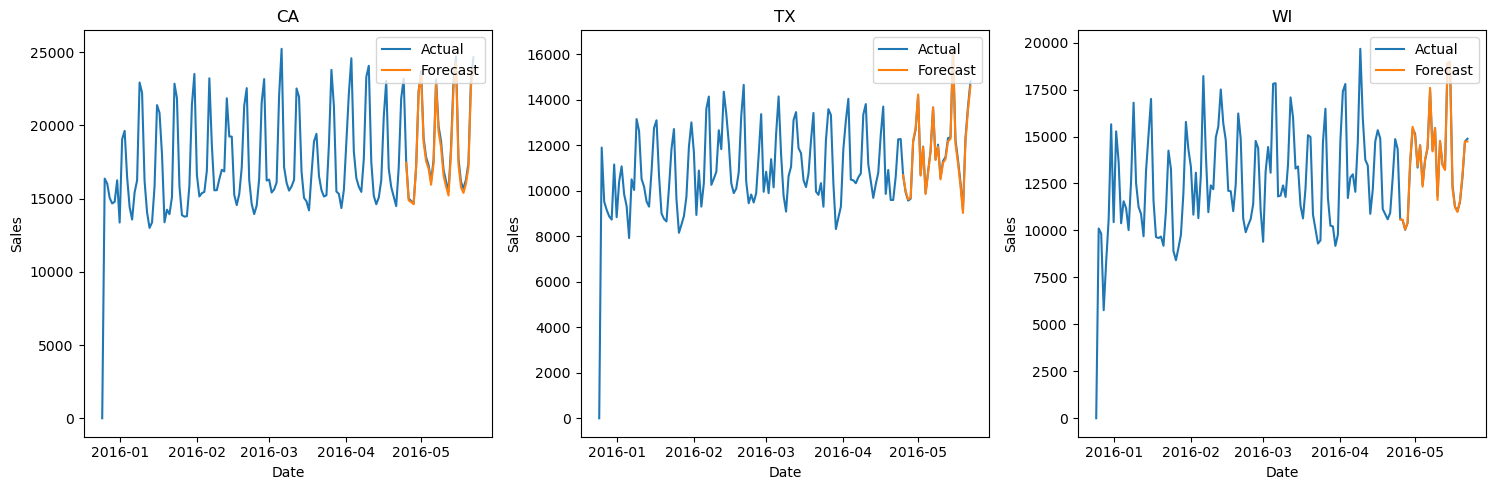

In [96]:
level_idx = 2
estimator = 'DeepAR'

ids = np.empty((0, ))
test_labels = np.empty((0, 28))
test_forecasts = np.empty((0, 28))

for level in range(level_idx, level_idx+1):
    level_dir = f"../result/level {level}"
    for model_dir in os.listdir(level_dir):
        if model_dir.startswith(estimator):
            model_path = os.path.join(level_dir, model_dir)
            if os.path.isdir(model_path):
                for root, dirs, files in os.walk(model_path):
                    for file in files:
                        if file.startswith('test_labels'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_labels = pd.read_pickle(pickle_file)
                        if file.startswith('test_forecasts'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_forecasts = pd.read_pickle(pickle_file)
    
    page = 0
    graphs_per_page = 25

    start_idx = page * graphs_per_page
    end_idx = start_idx + graphs_per_page

    num_plots = min(len(test_labels[start_idx:end_idx]), graphs_per_page)
    cols = 5
    rows = (num_plots + cols - 1) // cols 
    fig, axes = plt.subplots(rows, cols, figsize=(25, 5 * rows))

    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        ax.plot(test_labels[start_idx + i][-150:].to_timestamp(), label="Actual")
        ax.plot(pd.Series(test_forecasts[start_idx + i].quantile(0.5), index=test_forecasts[start_idx + i].start_date.to_timestamp() + pd.to_timedelta(range(len(test_forecasts[0].quantile(0.5))), unit='D')), label="Forecast")
        ax.set_title(f'{test_forecasts[start_idx + i].item_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend(loc="upper right")

    for j in range(num_plots, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()
    plt.close()